# Mobile - recharge

In [546]:
!pip install dfply

In [4]:
!pip install lifetimes

In [8]:
%load_ext autoreload
%aimport utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import random
import time, datetime
import os
from functools import reduce
import subprocess
from datetime import datetime, timedelta
from functools import reduce
import pandas as pd
import pathlib
from dfply import *
from lifetimes import BetaGeoFitter
import seaborn as sb
import matplotlib.pyplot as plt
import scipy
import numpy as np
from sklearn.metrics import mean_absolute_error
from utils import adjust_frequency_prediction


In [10]:
%matplotlib inline

# training and testing data

In [11]:
path = '/tmp/data/pengcheng/cltv-summary/'

In [12]:
test_start_date = datetime.strptime('2019-07-01', "%Y-%m-%d").date()
test_end_date = datetime.strptime('2019-12-31', "%Y-%m-%d").date()
test_duration = (test_end_date - test_start_date).days


In [13]:
training_path = os.path.join(path,'17.pkl')
testing_path = os.path.join(path,'17_testing.pkl')

## training data

In [588]:
training_df = pd.read_pickle(training_path)


In [589]:
training_df.describe()

,customer_id,frequency,recency,monetary_value,T,total_value
count,5.866916e+06,5.866916e+06,5.866916e+06,5.866916e+06,5.866916e+06,5.866916e+06
mean,6.503439e+08,3.944184e+00,5.686486e+01,2.416703e+02,1.221059e+02,1.273889e+03
std,3.915961e+08,7.107977e+00,6.310752e+01,8.043828e+03,5.032994e+01,2.360424e+04
min,6.830000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.097928e+08,0.000000e+00,0.000000e+00,3.500000e+01,8.600000e+01,7.000000e+01
50%,5.926928e+08,1.000000e+00,2.900000e+01,9.020000e+01,1.360000e+02,2.970000e+02
75%,1.066466e+09,5.000000e+00,1.150000e+02,1.596667e+02,1.660000e+02,1.030000e+03
max,1.147579e+09,1.800000e+02,1.800000e+02,9.999990e+05,1.800000e+02,1.070745e+07


In [590]:
training_df.head(5)

,customer_id,frequency,recency,monetary_value,T,total_value
0,7747,5,117.0,32.875000,178,526.0
1,50329,22,155.0,298.192322,162,7753.0
2,52001,4,162.0,54.142857,180,379.0
3,60691,1,24.0,232.000000,121,464.0
4,70593,0,0.0,399.000000,120,798.0


In [591]:
len(training_df)

5866916

In [592]:
training_df.recency.quantile([.25, .5, .75, .85, .95, .99])

0.25      0.0
0.50     29.0
0.75    115.0
0.85    147.0
0.95    169.0
0.99    177.0
Name: recency, dtype: float64

In [593]:
training_df.frequency.quantile([.25, .5, .75, .85, .95, .99])

0.25     0.0
0.50     1.0
0.75     5.0
0.85     8.0
0.95    17.0
0.99    31.0
Name: frequency, dtype: float64

In [612]:
training_df.total_value.quantile([.25, .5, .75, .85, .95, .99])

0.25      70.00
0.50     297.00
0.75    1030.00
0.85    1772.00
0.95    3593.25
0.99    7133.00
Name: total_value, dtype: float64

In [595]:
training_df[training_df.frequency > 180].head(2)

,customer_id,frequency,recency,monetary_value,T,total_value


In [596]:
training_df_filter = training_df[training_df.frequency < training_df.frequency.quantile(.99)]

In [597]:
training_df_filter.frequency.quantile([.25, .5, .75, .85, .95, .99])

0.25     0.0
0.50     1.0
0.75     5.0
0.85     8.0
0.95    15.0
0.99    24.0
Name: frequency, dtype: float64

In [598]:
#training_df_filter = training_df_filter[training_df_filter.total_value < 5000]

In [613]:
training_df_filter.total_value.quantile([.25, .5, .75, .85, .95, .99])

0.25      70.00
0.50     284.00
0.75     995.00
0.85    1688.00
0.95    3307.00
0.99    5872.77
Name: total_value, dtype: float64

In [614]:
training_df_filter.monetary_value.quantile([.25, .5, .75, .85, .95, .99])

0.25     35.000000
0.50     89.666664
0.75    160.454544
0.85    214.307693
0.95    399.000000
0.99    499.000000
Name: monetary_value, dtype: float64

## testing data

In [615]:
testing_df = pd.read_pickle(testing_path)


In [616]:
len(testing_df)

2854316

In [617]:
testing_df.head(5)

,customer_id,frequency,recency,monetary_value,T,total_value
0,50329,9,168.0,424.666656,178,5096.0
1,52001,3,149.0,71.599998,174,358.0
2,60691,5,155.0,203.714279,178,1426.0
3,70593,0,0.0,119.000000,30,119.0
4,74706,1,61.0,50.000000,127,150.0


In [618]:
testing_df.describe()

,customer_id,frequency,recency,monetary_value,T,total_value
count,2.854316e+06,2.854316e+06,2.854316e+06,2.854316e+06,2.854316e+06,2.854316e+06
mean,4.798332e+08,7.015593e+00,9.482183e+01,1.885471e+02,1.457367e+02,1.806828e+03
std,3.478855e+08,9.363479e+00,6.540769e+01,3.933385e+03,4.324795e+01,2.154348e+04
min,6.830000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.368354e+08,1.000000e+00,2.600000e+01,6.062840e+01,1.300000e+02,2.540000e+02
50%,4.107674e+08,4.000000e+00,1.100000e+02,1.200000e+02,1.640000e+02,8.430000e+02
75%,6.491265e+08,1.000000e+01,1.560000e+02,1.976667e+02,1.770000e+02,2.045000e+03
max,1.147574e+09,1.830000e+02,1.830000e+02,9.963360e+05,1.830000e+02,1.348741e+07


In [619]:
testing_df.frequency.quantile([.25, .5, .75, .85, .95, .99])

0.25     1.0
0.50     4.0
0.75    10.0
0.85    14.0
0.95    23.0
0.99    41.0
Name: frequency, dtype: float64

In [620]:
testing_df_filter = testing_df[testing_df.frequency < testing_df.frequency.quantile(.99)]

In [621]:
testing_df_filter.frequency.quantile([.25, .5, .75, .85, .95, .99])

0.25     1.0
0.50     4.0
0.75     9.0
0.85    13.0
0.95    22.0
0.99    32.0
Name: frequency, dtype: float64

In [622]:
testing_df_filter.monetary_value.quantile([.25, .5, .75, .85, .95, .99])

0.25     60.285713
0.50    120.300945
0.75    198.500000
0.85    259.000000
0.95    399.000000
0.99    545.269019
Name: monetary_value, dtype: float64

## as one

In [623]:
post_df = ( testing_df_filter >> rename(frequency_holdout = X.frequency, 
                                        id=X.customer_id, 
                                        money_holdout=X.monetary_value,
                                       total_holdout=X.total_value) 
          >> select(X.frequency_holdout, X.id, X.money_holdout, X.total_holdout))
post_df.head(1)

,frequency_holdout,id,money_holdout,total_holdout
0,9,50329,424.666656,5096.0


In [624]:
pre_df = ( training_df_filter >> rename(frequency_cal = 'frequency', recency_cal = 'recency', T_cal='T', id='customer_id') ) 
pre_df.head(1)

,id,frequency_cal,recency_cal,monetary_value,T_cal,total_value
0,7747,5,117.0,32.875,178,526.0


In [625]:
pre_post_df = pre_df >> left_join(post_df, by='id')

In [626]:
pre_post_df.head(1)

,id,frequency_cal,recency_cal,monetary_value,T_cal,total_value,frequency_holdout,money_holdout,total_holdout
0,7747,5,117.0,32.875,178,526.0,NaN,NaN,NaN


In [627]:
pre_post_df.frequency_holdout.fillna(0.0, inplace=True)

In [628]:
pre_post_df['duration_holdout'] = test_duration

In [629]:
pre_post_df.money_holdout.fillna(0.0, inplace=True)

In [630]:
pre_post_df.head(5)

,id,frequency_cal,recency_cal,monetary_value,T_cal,total_value,frequency_holdout,money_holdout,total_holdout,duration_holdout
0,7747,5,117.0,32.875000,178,526.0,0.0,0.000000,NaN,183
1,50329,22,155.0,298.192322,162,7753.0,9.0,424.666656,5096.0,183
2,52001,4,162.0,54.142857,180,379.0,3.0,71.599998,358.0,183
3,60691,1,24.0,232.000000,121,464.0,5.0,203.714279,1426.0,183
4,70593,0,0.0,399.000000,120,798.0,0.0,119.000000,119.0,183


In [631]:
len(pre_post_df)

5803924

# BetaGeo fit

In [632]:
mask=np.random.rand(len(pre_post_df)) <= 0.6

In [633]:
part = pre_post_df[mask]
#part = pre_post_df

In [634]:
part.head(3)

,id,frequency_cal,recency_cal,monetary_value,T_cal,total_value,frequency_holdout,money_holdout,total_holdout,duration_holdout
0,7747,5,117.0,32.875000,178,526.0,0.0,0.000000,NaN,183
2,52001,4,162.0,54.142857,180,379.0,3.0,71.599998,358.0,183
3,60691,1,24.0,232.000000,121,464.0,5.0,203.714279,1426.0,183


In [635]:
len(part)

3481218

## model fitting

In [636]:
bgf = BetaGeoFitter(penalizer_coef=0.00001)
bgf.fit(part['frequency_cal'], part['recency_cal'], part['T_cal'], verbose=True, tol=0.0001)
bgf

Optimization terminated successfully.
         Current function value: -3.648704
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24


<lifetimes.BetaGeoFitter: fitted with 3481218 subjects, a: 0.29, alpha: 15.28, b: 3.96, r: 0.51>

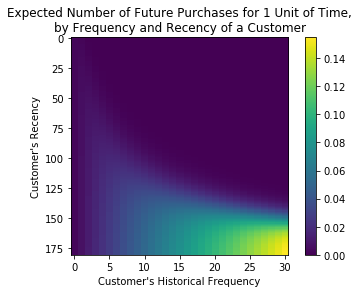

In [637]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

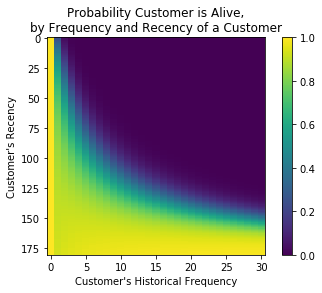

In [638]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

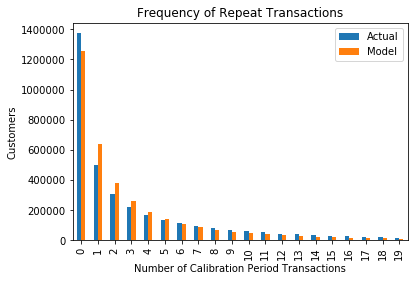

In [86]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf, max_frequency=20)

In [347]:
part.frequency_cal.quantile([.1, .2, .25, .5, .75, .85, .95, .99, .995])

0.100     0.0
0.200     0.0
0.250     0.0
0.500     1.0
0.750     4.0
0.850     7.0
0.950    14.0
0.990    22.0
0.995    25.0
Name: frequency_cal, dtype: float64

## customer alive history

In [348]:
from lifetimes.plotting import plot_history_alive

In [349]:
cst = utils.load_customer_alive_history(17).sort_values(by='dt')

   customer_id  price  category_id          dt
0       894577     50           17  2019-03-11
1       894577     30           17  2019-03-18


In [350]:
cst['dt'] = pd.to_datetime(cst.dt)

In [351]:
cst.customer_id.unique()

array([894577, 233176])

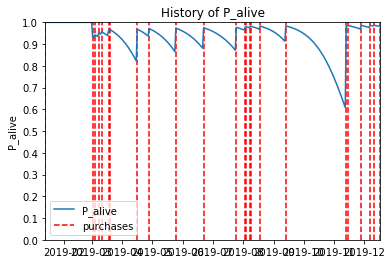

In [352]:
id = 894577
days_since_birth = 300
sp_trans = cst.loc[cst['customer_id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'dt', freq="D")

In [353]:
cst[cst.customer_id==894577].count()

customer_id    32
price          32
category_id    32
dt             32
dtype: int64

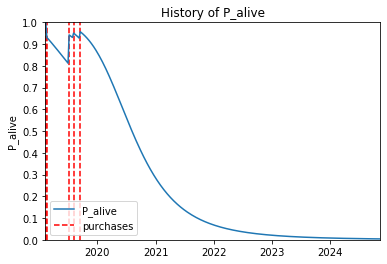

In [354]:
id = 233176
days_since_birth = 300
sp_trans = cst.loc[cst['customer_id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'dt', freq="W")

In [355]:
cst[cst.customer_id==233176].count()

customer_id    7
price          7
category_id    7
dt             7
dtype: int64

## model evaluation

In [639]:
t=180
part['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, part['frequency_cal'], part['recency_cal'], part['T_cal'])
part['palive'] = bgf.conditional_probability_alive(part['frequency_cal'], part['recency_cal'], part['T_cal'])

In [640]:
part.sort_values(by='predicted_purchases').head(5)

,id,frequency_cal,recency_cal,monetary_value,T_cal,total_value,frequency_holdout,money_holdout,total_holdout,duration_holdout,predicted_purchases,palive
2835256,1056014921,30,34.0,121.389999,177,12139.0,0.0,0.0,NaN,183,2.714819e-15,1.047198e-16
1673535,1049319440,29,36.0,76.935066,180,5924.0,0.0,0.0,NaN,183,2.006928e-14,8.117197e-16
2482089,655908197,23,24.0,12.545455,180,414.0,0.0,0.0,NaN,183,7.523121e-14,3.813410e-15
5763433,1005024445,30,41.0,74.289062,179,9509.0,0.0,0.0,NaN,183,1.128600e-13,4.395142e-15
4023671,1049174290,25,31.0,95.816093,180,8336.0,0.0,0.0,NaN,183,2.332655e-13,1.090347e-14


In [641]:
part.sort_values(by='predicted_purchases').tail(5)

,id,frequency_cal,recency_cal,monetary_value,T_cal,total_value,frequency_holdout,money_holdout,total_holdout,duration_holdout,predicted_purchases,palive
302163,491206210,19,19.0,117.209000,19,36452.0,0.0,0.000000,NaN,183,74.444028,0.987111
2318942,1123276818,25,30.0,107.054054,30,7922.0,0.0,0.000000,NaN,183,77.013362,0.989848
5568961,1119344079,29,38.0,124.358971,38,9700.0,0.0,0.000000,NaN,183,77.581191,0.991107
4914558,474515810,30,37.0,147.894730,38,11240.0,19.0,117.137253,5974.0,183,79.661750,0.984727
5396056,1139300820,30,33.0,99.431953,33,16804.0,0.0,0.000000,NaN,183,87.182477,0.991375


In [642]:
utils.adjust_frequency_prediction(part)

0.100     0.000000
0.250     0.000000
0.500     1.739239
0.750     4.802391
0.850     7.776369
0.950    13.858545
0.990    21.504782
0.995    23.842000
Name: predicted_purchases, dtype: float64


In [643]:
mae, by_interval, alive, mae1, by_interval1 = utils.perf_trax_freq_by_interval(part, 2)

In [644]:
print(mae, by_interval, alive, mae1, by_interval1)

2.588071198637958 0.6001907952906138 0.414156769268687 2.612666313916566 0.564692874735222


In [645]:
part.frequency_cal.describe()

count    3.481218e+06
mean     3.491841e+00
std      5.272400e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      5.000000e+00
max      3.000000e+01
Name: frequency_cal, dtype: float64

In [660]:
mean_absolute_error(part['frequency_cal'], part['pred'])

1.3387498077403828

In [661]:
mean_absolute_error(part['frequency_cal'], part['predicted_purchases'])

1.3387498077403828

In [662]:
part.frequency_holdout.describe()

count    3.481218e+06
mean     2.977947e+00
std      5.707203e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.000000e+00
max      4.000000e+01
Name: frequency_holdout, dtype: float64

In [663]:
part.frequency_holdout.quantile([0.75, 0.80, 0.85, 0.9, 0.95, 0.99])

0.75     4.0
0.80     5.0
0.85     7.0
0.90    10.0
0.95    16.0
0.99    26.0
Name: frequency_holdout, dtype: float64

In [664]:
part.predicted_purchases.describe()

count    3.481218e+06
mean     3.530786e+00
std      4.797678e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.739239e+00
75%      4.802391e+00
max      8.718248e+01
Name: predicted_purchases, dtype: float64

In [665]:
part.predicted_purchases.quantile([0.75, 0.80, 0.85, 0.9, 0.95, 0.99])

0.75     4.802391
0.80     6.114419
0.85     7.776369
0.90    10.059729
0.95    13.858545
0.99    21.504782
Name: predicted_purchases, dtype: float64

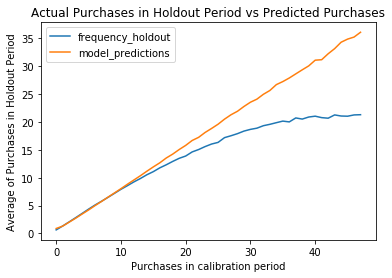

In [79]:
#from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
# ax = summary.groupby('frequency_cal')[["frequency_holdout", "model_predictions"]].mean().iloc[:n].plot(**kwargs)
#plot_calibration_purchases_vs_holdout_purchases(bgf, part, n=60)

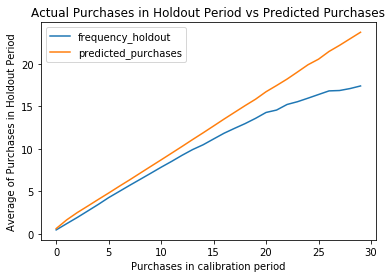

In [666]:
utils._plot_calibration_purchases_vs_holdout_purchases(part, 30)

## model save

In [87]:
bgf.save_model('17_bgf.pkl')

# Gamma Gamma fitting

In [667]:
part.monetary_value.describe()

count    3.481218e+06
mean     2.438771e+02
std      8.119273e+03
min      0.000000e+00
25%      3.500000e+01
50%      8.966666e+01
75%      1.604167e+02
max      9.999990e+05
Name: monetary_value, dtype: float64

In [668]:
part.money_holdout.describe()

count    3.481218e+06
mean     9.038342e+01
std      2.636400e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.157688e+02
max      9.963360e+05
Name: money_holdout, dtype: float64

In [669]:
#returning_train_df = training_df_filter[training_df_filter.monetary_value > 0]
returning_train_df = part[part.monetary_value > 0]
returning_train_df = returning_train_df[returning_train_df.frequency_cal>0]

In [670]:
returning_train_df.head(2)

,id,frequency_cal,recency_cal,monetary_value,T_cal,total_value,frequency_holdout,money_holdout,total_holdout,duration_holdout,predicted_purchases,palive,pred,pred_in,train_in,alive,avenue
0,7747,5,117.0,32.875000,178,526.0,0.0,0.000000,NaN,183,3.680335,0.774503,3.680335,0,0,0,36.347557
2,52001,4,162.0,54.142857,180,379.0,3.0,71.599998,358.0,183,3.633901,0.940098,3.633901,1,1,1,61.183812


In [671]:
returning_train_df['monetary_value'].describe()

count    2.105659e+06
mean     1.988457e+02
std      4.349070e+03
min      1.000000e+00
25%      5.280000e+01
50%      1.053750e+02
75%      1.750000e+02
max      9.070530e+05
Name: monetary_value, dtype: float64

In [672]:
returning_train_df['frequency_cal'].describe()

count    2.105659e+06
mean     5.772947e+00
std      5.726184e+00
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      3.000000e+01
Name: frequency_cal, dtype: float64

In [673]:
returning_train_df[['frequency_cal','monetary_value']].corr()

,frequency_cal,monetary_value
frequency_cal,1.000000,-0.007582
monetary_value,-0.007582,1.000000


## model fitting

In [674]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.05)
ggf.fit(returning_train_df['frequency_cal'], returning_train_df['monetary_value'], verbose=True, tol=0.0000001)
ggf

Optimization terminated successfully.
         Current function value: 7.072641
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13


<lifetimes.GammaGammaFitter: fitted with 2105659 subjects, p: 1.65, q: 0.28, v: 1.56>

In [675]:
part['avenue'] = ggf.conditional_expected_average_profit(
        part['frequency_cal'],
        part['monetary_value']
    )

In [676]:
part.money_holdout.fillna(0.0, inplace=True)

In [677]:
part.describe()

,id,frequency_cal,recency_cal,monetary_value,T_cal,total_value,frequency_holdout,money_holdout,total_holdout,duration_holdout,predicted_purchases,palive,pred,pred_in,train_in,alive,avenue
count,3.481218e+06,3.481218e+06,3.481218e+06,3.481218e+06,3.481218e+06,3.481218e+06,3.481218e+06,3.481218e+06,1.667474e+06,3481218.0,3.481218e+06,3.481218e+06,3.481218e+06,3.481218e+06,3.481218e+06,3.481218e+06,3.481218e+06
mean,6.527631e+08,3.491841e+00,5.566674e+01,2.438771e+02,1.215539e+02,1.187103e+03,2.977947e+00,9.038342e+01,1.638665e+03,183.0,3.530786e+00,8.630898e-01,3.530786e+00,6.001908e-01,5.646929e-01,4.141568e-01,1.592391e+02
std,3.919738e+08,5.272400e+00,6.236717e+01,8.119273e+03,5.031404e+01,2.411543e+04,5.707203e+00,2.636400e+03,2.429721e+04,0.0,4.797678e+00,2.220213e-01,4.797678e+00,4.898590e-01,4.957972e-01,4.925759e-01,5.379163e+03
min,6.830000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,183.0,0.000000e+00,1.047198e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.576996e+00
25%,3.106213e+08,0.000000e+00,0.000000e+00,3.500000e+01,8.600000e+01,7.000000e+01,0.000000e+00,0.000000e+00,2.450000e+02,183.0,0.000000e+00,8.394741e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.576996e+00
50%,5.950473e+08,1.000000e+00,2.800000e+01,8.966666e+01,1.350000e+02,2.830000e+02,0.000000e+00,0.000000e+00,8.070000e+02,183.0,1.739239e+00,9.593925e-01,1.739239e+00,1.000000e+00,1.000000e+00,0.000000e+00,5.387227e+01
75%,1.066977e+09,5.000000e+00,1.120000e+02,1.604167e+02,1.660000e+02,9.950000e+02,4.000000e+00,1.157688e+02,1.944000e+03,183.0,4.802391e+00,1.000000e+00,4.802391e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.494601e+02
max,1.147579e+09,3.000000e+01,1.800000e+02,9.999990e+05,1.800000e+02,1.070745e+07,4.000000e+01,9.963360e+05,1.348741e+07,183.0,8.718248e+01,1.000000e+00,8.718248e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.605094e+06


## evaluation

In [678]:
mean_absolute_error(part['avenue'], part['money_holdout'])

156.42255402876333

In [679]:
mean_absolute_error(part['monetary_value'], part['money_holdout'])

230.02863

In [680]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        part['frequency_cal'],
        part['monetary_value']
    ).mean(),
    part[part['frequency_cal']>0]['monetary_value'].mean()
))

Expected conditional average profit: 159.23911917219394, Average profit: 198.84546


# clv prediction

In [681]:
lifetime_values = ggf.customer_lifetime_value(bgf,
                                              part['frequency_cal'],
                                              part['recency_cal'],
                                              part['T_cal'],
                                              part['monetary_value'],
                                              time = 6,
                                              discount_rate=0.1,
                                              freq='D')

In [682]:
training_money = part >> bind_cols(lifetime_values)


In [683]:
training_money.head(2)

,id,frequency_cal,recency_cal,monetary_value,T_cal,total_value,frequency_holdout,money_holdout,total_holdout,duration_holdout,predicted_purchases,palive,pred,pred_in,train_in,alive,avenue,clv
0,7747,5,117.0,32.875000,178,526.0,0.0,0.000000,NaN,183,3.680335,0.774503,3.680335,0,0,0,36.347557,97.741531
2,52001,4,162.0,54.142857,180,379.0,3.0,71.599998,358.0,183,3.633901,0.940098,3.633901,1,1,1,61.183812,162.398931


In [684]:
training_money['alive_status'] = training_money.apply(utils.alive, axis=1)

In [685]:
training_money.loc[training_money['clv'] < 0, 'clv'] = 0

In [686]:
p=utils.clv_perf(training_money, 'total_holdout', 'money_holdout', 'frequency_holdout', 50000)

clv
MAE: 634.9354010893827 

clv*alive
MAE: 632.0762093179899 

ave*pred*alive
MAE: 628.460308673709 

ave*pred
MAE: 629.8227893215394


In [687]:
p=utils.clv_perf(training_money, 'total_value', 'monetary_value', 'frequency_cal', 50000)

clv
MAE: 625.0617388750456 

clv*alive
MAE: 635.5445426723481 

ave*pred*alive
MAE: 555.8965713083309 

ave*pred
MAE: 547.1071849154305


In [688]:
mean_absolute_error(training_money['total_value'], training_money['total_holdout'])

1129.2279

In [689]:
training_money['total_value'].describe()

count    3.481218e+06
mean     1.187103e+03
std      2.411543e+04
min      0.000000e+00
25%      7.000000e+01
50%      2.830000e+02
75%      9.950000e+02
max      1.070745e+07
Name: total_value, dtype: float64

In [690]:
training_money['total_holdout'].describe()

count    3.481218e+06
mean     7.849066e+02
std      1.683582e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.490000e+02
max      1.348741e+07
Name: total_holdout, dtype: float64

In [691]:
training_money['clv'].describe()

count    3.481218e+06
mean     4.916999e+02
std      1.129212e+04
min      0.000000e+00
25%      0.000000e+00
50%      7.375967e+01
75%      5.148515e+02
max      7.856627e+06
Name: clv, dtype: float64

In [692]:
p['clv_1'].describe()

count    3.480160e+06
mean     3.612323e+02
std      6.807717e+02
min      0.000000e+00
25%      0.000000e+00
50%      3.893505e+01
75%      5.073322e+02
max      4.990467e+04
Name: clv_1, dtype: float64

In [693]:
p['clv_2'].describe()

count    3.480160e+06
mean     4.911927e+02
std      9.279279e+02
min     -0.000000e+00
25%     -0.000000e+00
50%      3.015562e+01
75%      6.926524e+02
max      6.827942e+04
Name: clv_2, dtype: float64

In [694]:
training_money["total_holdout"].quantile([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])

0.50           0.0
0.60         135.0
0.70         475.0
0.80        1092.0
0.90        2243.0
0.95        3411.0
0.99        6237.0
1.00    13487413.0
Name: total_holdout, dtype: float64

In [695]:
p["clv_1"].quantile([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.50      38.935047
0.60     157.635614
0.70     367.832173
0.80     674.513996
0.90    1156.100705
0.95    1616.270585
0.99    2684.209466
Name: clv_1, dtype: float64

In [696]:
p["clv_2"].quantile([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.50      30.155624
0.60     208.650352
0.70     500.608846
0.80     921.412696
0.90    1578.547618
0.95    2206.239708
0.99    3661.657601
Name: clv_2, dtype: float64

# Regression metric

In [737]:
from importlib import reload
reload(utils)

<module 'utils' from '/home/jovyan/public/notebooks/pengcheng/cltv/utils.py'>

In [697]:
bins = utils.get_bins(training_money, 'total_holdout')
bins

[0,
 68.0,
 169.0,
 350.0,
 531.0,
 807.0,
 1166.0,
 1638.0,
 2316.0,
 3484.0,
 13487413.0]

In [738]:
holdout_bin, predicted_bin, training_bin = utils.bucket_mean(training_money, 'total_holdout', 
                                                             'total_holdout', 'clv', 'total_value', 'holdout_cltv_decile', bins)

TPR:  0.6178659584474385
FPR:  0.15286779288585622


In [699]:
predicted_bin

,mean,count,bins
holdout_cltv_decile,,,
0,193.706170,1813751,0.0
1,377.311814,167361,68.0
2,452.435596,166414,169.0
3,557.236446,166579,350.0
4,575.982515,166732,531.0
5,657.956466,167067,807.0
6,705.369003,166666,1166.0
7,846.596484,166608,1638.0
8,1010.395491,166607,2316.0


In [700]:
holdout_bin

,mean,count,bins
holdout_cltv_decile,,,
0,0.000000,1813751,0.0
1,33.885483,167361,68.0
2,117.858002,166414,169.0
3,251.080887,166579,350.0
4,437.481567,166732,531.0
5,665.886475,167067,807.0
6,975.410339,166666,1166.0
7,1386.527222,166608,1638.0
8,1953.199829,166607,2316.0


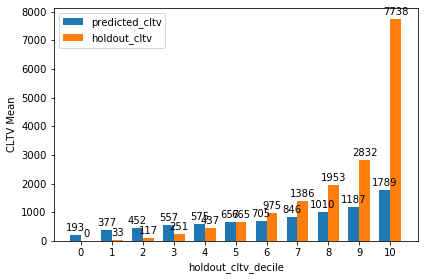

In [723]:
utils.plot_bucket_mean_(predicted_bin, holdout_bin, 'predicted_cltv', 'holdout_cltv')

In [702]:
mean_diff=utils.mape(predicted_bin['mean'], holdout_bin['mean'])

In [703]:
mean_diff

[(193.7061704816073, 0.0, 193.7061704816073),
 (377.31181368863906, 33.885483, 10.134910369974161),
 (452.43559577071727, 117.858, 2.838819504914683),
 (557.2364461800298, 251.08089, 1.219350318502361),
 (575.9825146794873, 437.48157, 0.31658693216549016),
 (657.9564655698716, 665.8865, 0.011908950462096874),
 (705.3690026871084, 975.41034, 0.27684895861038156),
 (846.5964837949281, 1386.5272, 0.38941228808379863),
 (1010.3954909585035, 1953.1998, 0.48269732778787533),
 (1187.4803369840174, 2832.539, 0.5807717702096059),
 (1789.0885066716767, 7738.779, 0.768815138548096)]

In [725]:
diffs = [round(mean_diff[i][2],3) for i in range(1, len(mean_diff))]
sum(diffs)/len(diffs)

1.7020999999999997

In [726]:
diffs

[10.135, 2.839, 1.219, 0.317, 0.012, 0.277, 0.389, 0.483, 0.581, 0.769]

In [706]:
training_bin

,mean,count,bins
holdout_cltv_decile,,,
0,776.339111,1813751,0.0
1,812.128479,167361,68.0
2,934.817444,166414,169.0
3,1077.601440,166579,350.0
4,1162.063232,166732,531.0
5,1249.971802,167067,807.0
6,1445.504761,166666,1166.0
7,1699.545166,166608,1638.0
8,1935.508057,166607,2316.0


In [707]:
mean_diff2=utils.mape(training_bin['mean'], holdout_bin['mean'])

In [708]:
mean_diff2

[(776.3391, 0.0, 776.3391),
 (812.1285, 33.885483, 22.966856),
 (934.81744, 117.858, 6.931727),
 (1077.6014, 251.08089, 3.2918499),
 (1162.0632, 437.48157, 1.6562564),
 (1249.9718, 665.8865, 0.8771545),
 (1445.5048, 975.41034, 0.4819453),
 (1699.5452, 1386.5272, 0.2257568),
 (1935.508, 1953.1998, 0.00905784),
 (2368.2798, 2832.539, 0.16390216),
 (3656.521, 7738.779, 0.5275067)]

In [709]:
diffs2 = [round(mean_diff2[i][2],3) for i in range(1, len(mean_diff2))]
sum(diffs2)/len(diffs2)

3.7132999252527954

In [710]:
diffs2

[22.967, 6.932, 3.292, 1.656, 0.877, 0.482, 0.226, 0.009, 0.164, 0.528]

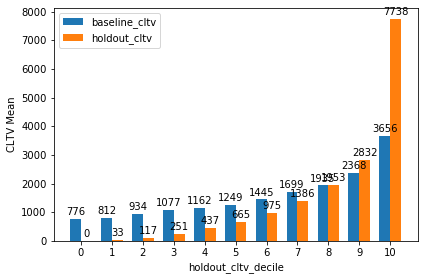

In [724]:
utils.plot_bucket_mean_(training_bin, holdout_bin, 'baseline_cltv', 'holdout_cltv')

# Ranking metric

In [712]:
utils.spearman_cor(training_money, 'total_holdout', 'clv')

3481218 2360563 0.678085371269481


SpearmanrResult(correlation=0.46467416065181844, pvalue=0.0)

In [713]:
utils.spearman_cor(training_money, 'total_holdout', 'total_value')

3481218 3480593 0.9998204651360529


SpearmanrResult(correlation=0.5889840619902156, pvalue=0.0)

# Classification metric

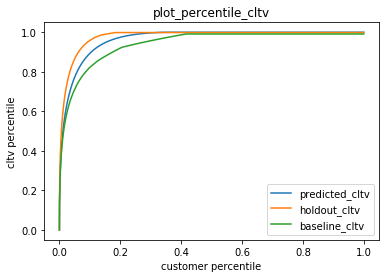

In [714]:
x1, y1, x2, y2, x3, y3 = utils.plot_percentile_cltv(training_money, 'clv', 
                                                    'total_holdout', 'total_value', 0.99, .99, .99, 'dense')




In [715]:
len(x1)

3446405

In [716]:
utils.gini(training_money, 'total_holdout', 'clv')

(0.824846319777335, 0.7954826222125245)

In [717]:
utils.gini(training_money, 'total_holdout', 'total_value')

(0.824846319777335, 0.7759543957773105)